In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from PIL import Image
import glob

from sklearn.model_selection import train_test_split

import tensorflow as tf 
from tensorflow.keras.preprocessing import image

2024-12-07 16:57:20.137042: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path = "/Users/manuelcunha/Desktop/Pós-Graduação/2º Semestre/Deep Learning Neural Networks/Project/BreaKHis_v1 2"

#os.listdir(path)

In [3]:
for dirname, _, filenames in os.walk('/Users/manuelcunha/Desktop/Pós-Graduação/2º Semestre/Deep Learning Neural Networks/Project/BreaKHis_v1 2'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/manuelcunha/Desktop/Pós-Graduação/2º Semestre/Deep Learning Neural Networks/Project/BreaKHis_v1 2/.DS_Store
/Users/manuelcunha/Desktop/Pós-Graduação/2º Semestre/Deep Learning Neural Networks/Project/BreaKHis_v1 2/histology_slides/.DS_Store
/Users/manuelcunha/Desktop/Pós-Graduação/2º Semestre/Deep Learning Neural Networks/Project/BreaKHis_v1 2/histology_slides/breast/.DS_Store
/Users/manuelcunha/Desktop/Pós-Graduação/2º Semestre/Deep Learning Neural Networks/Project/BreaKHis_v1 2/histology_slides/breast/image_data.csv
/Users/manuelcunha/Desktop/Pós-Graduação/2º Semestre/Deep Learning Neural Networks/Project/BreaKHis_v1 2/histology_slides/breast/malignant/.DS_Store
/Users/manuelcunha/Desktop/Pós-Graduação/2º Semestre/Deep Learning Neural Networks/Project/BreaKHis_v1 2/histology_slides/breast/malignant/SOB/.DS_Store
/Users/manuelcunha/Desktop/Pós-Graduação/2º Semestre/Deep Learning Neural Networks/Project/BreaKHis_v1 2/histology_slides/breast/malignant/SOB/muci

In [4]:
# Define dataset directory
dataset_dir = "/Users/manuelcunha/Desktop/Pós-Graduação/2º Semestre/Deep Learning Neural Networks/Project/BreaKHis_v1 2/histology_slides/breast"

# Data lists
data_info = []

# Updated regular expression to parse filenames
filename_pattern = re.compile(
    r"SOB_(?P<class>[BM])_(?P<type>[A-Z]+)[-_](?P<year>\d+)-(?P<slide_id>[\dA-Z]+)-(?P<mag>\d+)-(?P<seq>\d+).png"
)

# Define magnification levels and tumor types
magnification_levels = {"40", "100", "200", "400"}
benign_types = {"A", "F", "PT", "TA"} 
malignant_types = {"DC", "LC", "MC", "PC"}

# Walk through dataset directory
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith(".png"):
            file_path = os.path.join(root, file)
            match = filename_pattern.match(file)
            if match:
                # Extract information from filename
                tumor_class = match.group("class")
                tumor_type = match.group("type")
                year = match.group("year")
                slide_id = match.group("slide_id")
                magnification = match.group("mag")
                sequence = match.group("seq")
                
                # Validate tumor type and magnification level
                if tumor_class == "B" and tumor_type not in benign_types:
                    continue
                if tumor_class == "M" and tumor_type not in malignant_types:
                    continue
                if magnification not in magnification_levels:
                    continue
                
                # Add image details to data list
                data_info.append({
                    "file_path": file_path,
                    "tumor_class": "Benign" if tumor_class == "B" else "Malignant",
                    "tumor_type": tumor_type,
                    "magnification": magnification,
                    "year": year,
                    "slide_id": slide_id,
                    "sequence": sequence
                })

# Convert data info to DataFrame for better handling
df = pd.DataFrame(data_info)



In [5]:
data_info

[{'file_path': '/Users/manuelcunha/Desktop/Pós-Graduação/2º Semestre/Deep Learning Neural Networks/Project/BreaKHis_v1 2/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/100X/SOB_M_MC-14-13418DE-100-009.png',
  'tumor_class': 'Malignant',
  'tumor_type': 'MC',
  'magnification': '100',
  'year': '14',
  'slide_id': '13418DE',
  'sequence': '009'},
 {'file_path': '/Users/manuelcunha/Desktop/Pós-Graduação/2º Semestre/Deep Learning Neural Networks/Project/BreaKHis_v1 2/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/100X/SOB_M_MC-14-13418DE-100-008.png',
  'tumor_class': 'Malignant',
  'tumor_type': 'MC',
  'magnification': '100',
  'year': '14',
  'slide_id': '13418DE',
  'sequence': '008'},
 {'file_path': '/Users/manuelcunha/Desktop/Pós-Graduação/2º Semestre/Deep Learning Neural Networks/Project/BreaKHis_v1 2/histology_slides/breast/malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-13418DE/100X/SOB_M_MC-14-13418DE-100-003.png'

#### Exploration Data Analysis

In [6]:
# Display dataset summary
print(f"Dataset contains {len(df)} images.")

# Calculate raw counts and percentages
tumor_summary = df["tumor_class"].value_counts().reset_index()
tumor_summary.columns = ["Tumor Class", "Count"]
tumor_summary["Percentage (%)"] = round((tumor_summary["Count"] / len(df)) * 100, 2)

# Summary of tumor classes and types
print("\nSummary of tumor classes:")
print(tumor_summary)

print("\nSummary of tumor types:")
print(df[["tumor_class","tumor_type"]].value_counts())

Dataset contains 7909 images.

Summary of tumor classes:
  Tumor Class  Count  Percentage (%)
0   Malignant   5429           68.64
1      Benign   2480           31.36

Summary of tumor types:
tumor_class  tumor_type
Malignant    DC            3451
Benign       F             1014
Malignant    MC             792
             LC             626
Benign       TA             569
Malignant    PC             560
Benign       PT             453
             A              444
Name: count, dtype: int64


##### Check for duplicated images

In [1]:
# check

/var/folders/x3/sldfx88s0r38rjmf6v0l9v7r0000gp/T/ipykernel_2010/1940207312.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=benign_grouped, x='magnification', y='Count', palette='viridis')


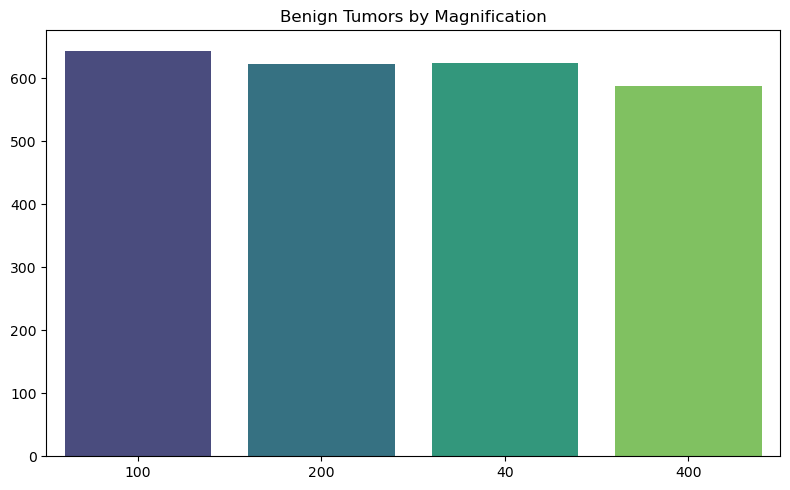

/var/folders/x3/sldfx88s0r38rjmf6v0l9v7r0000gp/T/ipykernel_2010/1940207312.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=malignant_grouped, x='magnification', y='Count', palette='viridis')


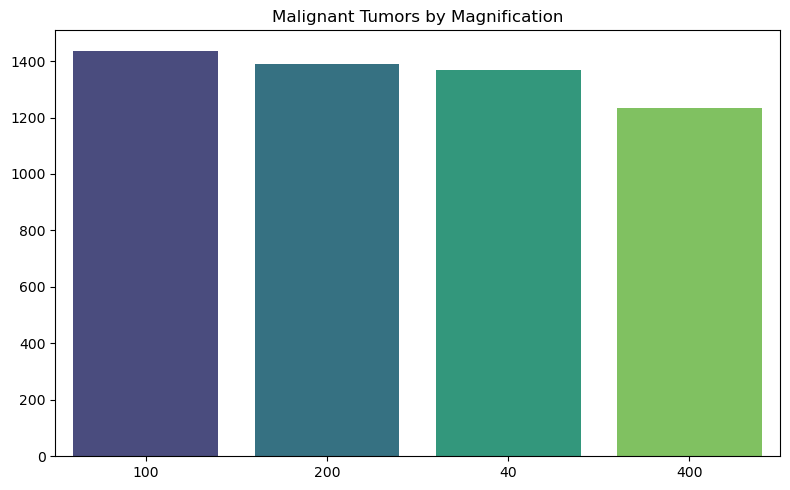

In [7]:
benign_data = df[df['tumor_class'] == 'Benign']
malignant_data = df[df['tumor_class'] == 'Malignant']

# Group for Benign tumors
benign_grouped = benign_data.groupby('magnification').size().reset_index(name='Count')

# Group for Malignant tumors
malignant_grouped = malignant_data.groupby('magnification').size().reset_index(name='Count')

# Plot for Benign tumors
plt.figure(figsize=(8, 5))
sns.barplot(data=benign_grouped, x='magnification', y='Count', palette='viridis')
plt.title('Benign Tumors by Magnification', fontsize=12)
plt.xlabel('', fontsize=10)  # No label for x-axis
plt.ylabel('', fontsize=10)  # No label for y-axis
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Plot for Malignant tumors
plt.figure(figsize=(8, 5))
sns.barplot(data=malignant_grouped, x='magnification', y='Count', palette='viridis')
plt.title('Malignant Tumors by Magnification', fontsize=12)
plt.xlabel('', fontsize=10)  # No label for x-axis
plt.ylabel('', fontsize=10)  # No label for y-axis
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


### Binary classification

In [8]:
'''
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Initialize lists for benign and malignant images
benign_images = []
malignant_images = []

# Iterate over the DataFrame rows
for index, row in df.iterrows():
    # Load the image using the file_path column
    img = load_img(row['file_path'], target_size=(224, 224))  # Resize images to 224x224
    img_array = img_to_array(img)  # Convert image to array

    # Append to the appropriate list based on tumor class
    if row['tumor_class'] == 'Benign':
        benign_images.append(img_array)
    elif row['tumor_class'] == 'Malignant':
        malignant_images.append(img_array)

print(f"Total Benign Images: {len(benign_images)}")
print(f"Total Malignant Images: {len(malignant_images)}")
'''


'\nfrom tensorflow.keras.preprocessing.image import img_to_array, load_img\n\n# Initialize lists for benign and malignant images\nbenign_images = []\nmalignant_images = []\n\n# Iterate over the DataFrame rows\nfor index, row in df.iterrows():\n    # Load the image using the file_path column\n    img = load_img(row[\'file_path\'], target_size=(224, 224))  # Resize images to 224x224\n    img_array = img_to_array(img)  # Convert image to array\n\n    # Append to the appropriate list based on tumor class\n    if row[\'tumor_class\'] == \'Benign\':\n        benign_images.append(img_array)\n    elif row[\'tumor_class\'] == \'Malignant\':\n        malignant_images.append(img_array)\n\nprint(f"Total Benign Images: {len(benign_images)}")\nprint(f"Total Malignant Images: {len(malignant_images)}")\n'

In [9]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

# Initialize an empty list for image data
image_data = []

# Iterate over the DataFrame rows
for index, row in df.iterrows():
    try:
        # Load the image using the file_path column
        img = load_img(row['file_path'], target_size=(224, 224))  # Resize images to 224x224
        img_array = img_to_array(img)  # Convert image to array
        
        # Append the image array to the list
        image_data.append(img_array)
    except Exception as e:
        print(f"Error processing file {row['file_path']}: {e}")
        image_data.append(None)  # Append None if the image could not be processed

# Add the image data to the DataFrame
df['image_data'] = image_data

# Optional: Filter out rows with invalid images
df = df[df['image_data'].notnull()]

print(f"Total Images Processed: {len(df)}")


Total Images Processed: 7909


In [10]:
df

,file_path,tumor_class,tumor_type,magnification,year,slide_id,sequence,image_data
0,/Users/manuelcunha/Desktop/Pós-Graduação/2º...,Malignant,MC,100,14,13418DE,009,"[[[251.0, 252.0, 246.0], [251.0, 250.0, 245.0]..."
1,/Users/manuelcunha/Desktop/Pós-Graduação/2º...,Malignant,MC,100,14,13418DE,008,"[[[201.0, 192.0, 195.0], [224.0, 219.0, 216.0]..."
2,/Users/manuelcunha/Desktop/Pós-Graduação/2º...,Malignant,MC,100,14,13418DE,003,"[[[160.0, 145.0, 166.0], [171.0, 156.0, 175.0]..."
3,/Users/manuelcunha/Desktop/Pós-Graduação/2º...,Malignant,MC,100,14,13418DE,002,"[[[234.0, 231.0, 238.0], [234.0, 231.0, 238.0]..."
4,/Users/manuelcunha/Desktop/Pós-Graduação/2º...,Malignant,MC,100,14,13418DE,014,"[[[201.0, 187.0, 202.0], [205.0, 188.0, 204.0]..."
...,...,...,...,...,...,...,...,...
7904,/Users/manuelcunha/Desktop/Pós-Graduação/2º...,Benign,PT,200,14,29315EF,005,"[[[210.0, 231.0, 224.0], [205.0, 227.0, 225.0]..."
7905,/Users/manuelcunha/Desktop/Pós-Graduação/2º...,Benign,PT,200,14,29315EF,013,"[[[224.0, 254.0, 252.0], [223.0, 255.0, 252.0]..."
7906,/Users/manuelcunha/Desktop/Pós-Graduação/2º...,Benign,PT,200,14,29315EF,007,"[[[210.0, 186.0, 199.0], [224.0, 214.0, 225.0]..."
7907,/Users/manuelcunha/Desktop/Pós-Graduação/2º...,Benign,PT,200,14,29315EF,006,"[[[205.0, 172.0, 199.0], [220.0, 186.0, 213.0]..."


#### Target variable and Train, test split

In [20]:
df['target'] = df['tumor_class'].apply(lambda x: 0 if x == "Benign" else 1)

df['target_array'] = df['target'].values


In [21]:
X_train, X_test, y_train, y_test = train_test_split(df, df['target'], test_size=0.10, stratify=df['target'], random_state = 1, shuffle = True)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state = 1, stratify=y_train, shuffle=True)

In [23]:
X_train

KeyboardInterrupt: 

### Models

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

# Example DataFrame
# Replace this with your actual data
# df = pd.DataFrame({
#     'file_path': ['/path1/image1.png', '/path2/image2.png', '/path3/image3.png'],
#     'tumor_type': ['A', 'DC', 'PT'],
#     'target': [0, 1, 0]
# })

# Encode categorical variables
#le_file_path = LabelEncoder()
#df['file_path_encoded'] = le_file_path.fit_transform(df['file_path'])

#le_tumor_type = LabelEncoder()
#df['tumor_type_encoded'] = le_tumor_type.fit_transform(df['tumor_type'])

# Define features (X) and target (y)
X = df[['image_data']].values
y = df['target_array'].values

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the Sequential model
model = Sequential()

# First hidden layer with input_dim specified
model.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))

# Second hidden layer
model.add(Dense(16, activation='relu'))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=500, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Display sample predictions
print("Sample Predictions:")
for i in range(5):  # Show the first 5 predictions
    print(f"Predicted: {y_pred[i][0]}, Actual: {y_test[i]}")


ValueError: setting an array element with a sequence.

#### Model 1

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop


# Encode magnification levels as numerical values
le_file_path = LabelEncoder()
df['file_path_encoded'] = le_file_path.fit_transform(df['path_category'])

le_tumor_type = LabelEncoder()
df['tumor_type_encoded'] = le_tumor_type.fit_transform(df['tumor_type'])

# Define features (X) and target (y)
X = df[['file_path_encoded', 'tumor_type_encoded']].values
y = df['target'].values

# Split the dataset into training and testing subsets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the Sequential model
model = Sequential()

# First hidden layer with input_dim specified
model.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))

# Second hidden layer
model.add(Dense(16, activation='relu'))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=500, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")


KeyError: 'path_category'

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 644 (2.52 KB)

 Trainable params: 321 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 323 (1.27 KB)

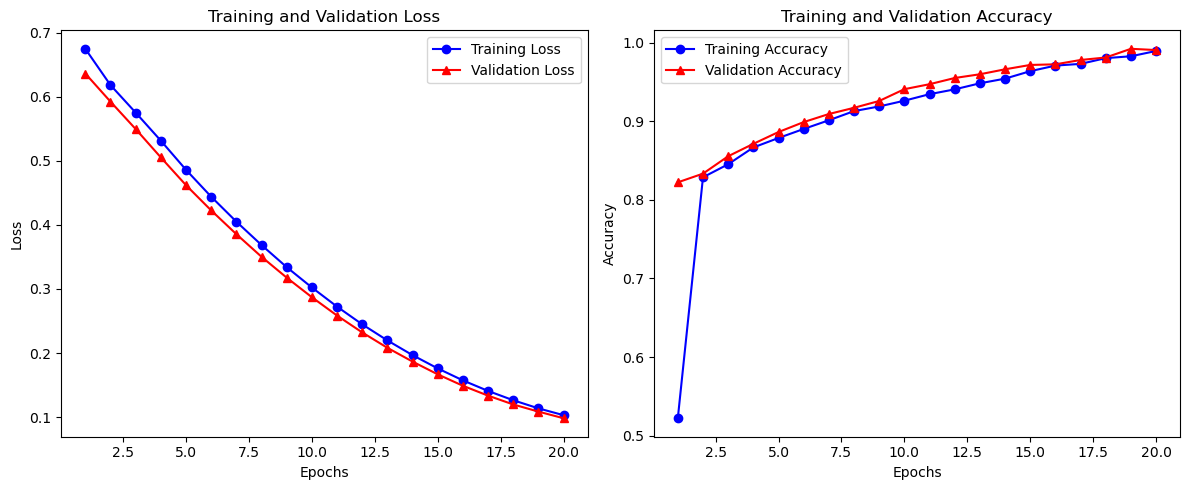

In [ ]:
import matplotlib.pyplot as plt

# Extracting data from the history object
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Generate the range for epochs
epochs = range(1, len(train_loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r^-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions
y_pred_prob = model.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary labels

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC-AUC Score: {roc_auc:.4f}")


Test Loss: 0.1012
Test Accuracy: 0.9823
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       496
           1       1.00      0.97      0.99      1086

    accuracy                           0.98      1582
   macro avg       0.97      0.99      0.98      1582
weighted avg       0.98      0.98      0.98      1582


ROC-AUC Score: 1.0000


In [ ]:
# Evaluate the model on the test set
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

Test Loss: 0.6215
Test Accuracy: 0.6896


In [ ]:
# Generate predictions
y_pred_prob = model.predict(X_test)  # Predicted probabilities for class 1
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Display some predicted probabilities and corresponding predictions
print("\nSample Predictions (Probability -> Binary):")
for i in range(10):  # Show the first 5 predictions
    print(f"Probability: {y_pred_prob[i][0]:.4f}, Predicted Class: {y_pred[i][0]}, Actual Class: {y_test[i]}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Sample Predictions (Probability -> Binary):
Probability: 0.6892, Predicted Class: 1, Actual Class: 1
Probability: 0.6714, Predicted Class: 1, Actual Class: 0
Probability: 0.6939, Predicted Class: 1, Actual Class: 1
Probability: 0.6714, Predicted Class: 1, Actual Class: 1
Probability: 0.6714, Predicted Class: 1, Actual Class: 1
Probability: 0.6595, Predicted Class: 1, Actual Class: 0
Probability: 0.6595, Predicted Class: 1, Actual Class: 1
Probability: 0.6892, Predicted Class: 1, Actual Class: 0
Probability: 0.6892, Predicted Class: 1, Actual Class: 1
Probability: 0.6892, Predicted Class: 1, Actual Class: 1


#### Model 2

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

# Example Dataset Creation
# Simulating a dataset with 1000 samples
np.random.seed(42)
num_samples = 1000

# Randomly assigning magnification levels and tumor types
magnification_levels = ["40", "100", "200", "400"]
benign_types = ["A", "F", "PT", "TA"]
malignant_types = ["DC", "LC", "MC", "PC"]

data = {
    "magnification": np.random.choice(magnification_levels, num_samples),
    "type": np.random.choice(benign_types + malignant_types, num_samples)
}

df = pd.DataFrame(data)

# Assign target labels (0 for benign, 1 for malignant)
df['target'] = df['type'].apply(lambda x: 0 if x in benign_types else 1)

# Encode magnification levels as numerical values
magnification_mapping = {level: idx for idx, level in enumerate(magnification_levels)}
df['magnification_encoded'] = df['magnification'].map(magnification_mapping)

# Define features (X) and target (y)
X = df[['magnification_encoded']].values
y = df['target'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the model
model = Sequential()

# Input and first hidden layer
model.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))

# Second hidden layer
model.add(Dense(16, activation='relu'))

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=512, validation_split=0.2, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")


Epoch 1/20


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 612ms/step - accuracy: 0.5105 - loss: 0.6945 - val_accuracy: 0.4938 - val_loss: 0.6917
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5099 - loss: 0.6939 - val_accuracy: 0.5375 - val_loss: 0.6914
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.5059 - loss: 0.6935 - val_accuracy: 0.4938 - val_loss: 0.6915
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.5138 - loss: 0.6927 - val_accuracy: 0.5375 - val_loss: 0.6911
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5078 - loss: 0.6926 - val_accuracy: 0.4938 - val_loss: 0.6912
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5099 - loss: 0.6928 - val_accuracy: 0.4938 - val_loss: 0.6913
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5099 - loss: 0.6928 - val_accuracy: 0.4938 - val_loss: 0.6913
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5112 - loss: 0.6926 - val_accuracy: 0.4938 - val_loss: 0.6912
Epo

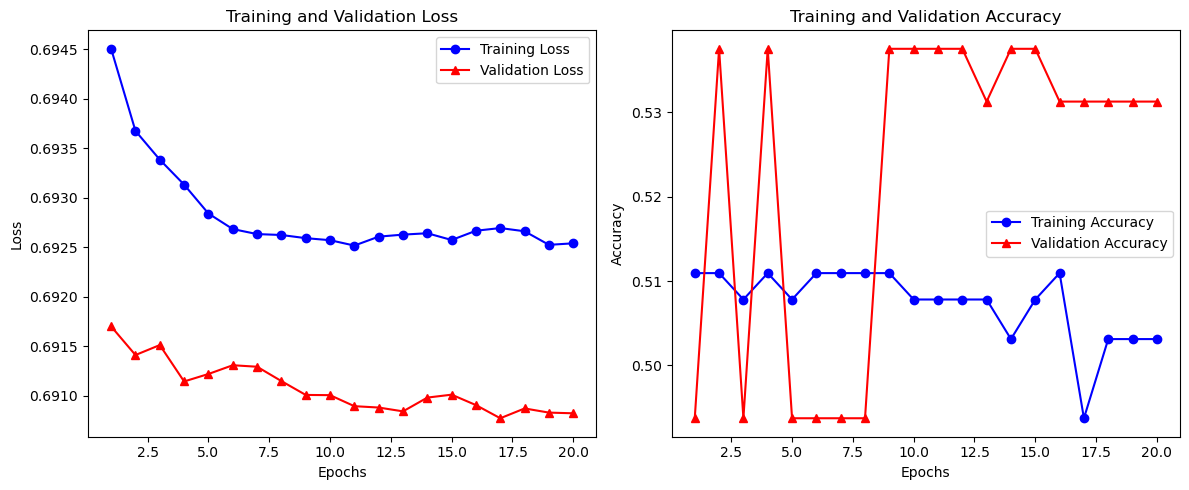

In [ ]:
import matplotlib.pyplot as plt

# Extracting data from the history object
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

# Generate the range for epochs
epochs = range(1, len(train_loss) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r^-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Generate predictions
y_pred_prob = model.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary labels

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nROC-AUC Score: {roc_auc:.4f}")


Test Loss: 0.6942
Test Accuracy: 0.5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.49      0.51       107
           1       0.47      0.52      0.49        93

    accuracy                           0.50       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.50      0.50      0.50       200


ROC-AUC Score: 0.5215


In [ ]:
# Evaluate the model on the test set
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

Test Loss: 0.6942
Test Accuracy: 0.5000


In [ ]:
# Generate predictions
y_pred_prob = model.predict(X_test)  # Predicted probabilities for class 1
y_pred = (y_pred_prob > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Display some predicted probabilities and corresponding predictions
print("\nSample Predictions (Probability -> Binary):")
for i in range(10):  # Show the first 5 predictions
    print(f"Probability: {y_pred_prob[i][0]:.4f}, Predicted Class: {y_pred[i][0]}, Actual Class: {y_test[i]}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Sample Predictions (Probability -> Binary):
Probability: 0.4946, Predicted Class: 0, Actual Class: 0
Probability: 0.5358, Predicted Class: 1, Actual Class: 1
Probability: 0.4946, Predicted Class: 0, Actual Class: 1
Probability: 0.4971, Predicted Class: 0, Actual Class: 0
Probability: 0.4971, Predicted Class: 0, Actual Class: 0
Probability: 0.5007, Predicted Class: 1, Actual Class: 1
Probability: 0.5358, Predicted Class: 1, Actual Class: 0
Probability: 0.5007, Predicted Class: 1, Actual Class: 0
Probability: 0.4946, Predicted Class: 0, Actual Class: 0
Probability: 0.5358, Predicted Class: 1, Actual Class: 1
